# Raw _P(s)_ curves by strand orientation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocess as mp
import numpy as np
import pandas as pd
import pypairix
import bioframe
import cooltools

In [2]:
mm9 = bioframe.fetch_chromsizes('mm9')
chromsizes = bioframe.fetch_chromsizes('mm9')
chromosomes = list(chromsizes.index)

In [3]:
conditions = ['WT', 'dN']
binsize = 100000

pairs_paths = {
    'WT': 'data/UNTR_R1.nodups.pairs.gz',
    'dN': 'data/NIPBL_R1.nodups.pairs.gz'
}

long_names = {
    'WT': 'Wildtype',
    'dN': 'NipblKO',
}

pal = sns.color_palette('colorblind')
colors = {
    'WT': pal[0],
    'dN': pal[2],
}

In [4]:
from cooltools.expected import compute_scaling
import bioframe.dask

In [5]:
pairs_header = ['read_id', 'chrom1', 'pos1', 'chrom2', 'pos2', 'strand1', 'strand2', 'pair_type']
chrom = 'chr1'

df = bioframe.dask.read_pairix_block(
    pairs_paths['WT'], 
    (chrom, chrom),
    names=pairs_header,
    chunk_level=0)

In [6]:
df = df.compute()
print(len(df))
df.head()

4893134


,read_id,chrom1,pos1,chrom2,pos2,strand1,strand2,pair_type
0,.,chr1,3000031,chr1,3002463,-,+,LL
1,.,chr1,3000031,chr1,64746728,-,+,LL
2,.,chr1,3000036,chr1,12271809,-,+,LL
3,.,chr1,3000042,chr1,3009611,-,+,LL
4,.,chr1,3000048,chr1,4637504,-,+,LL


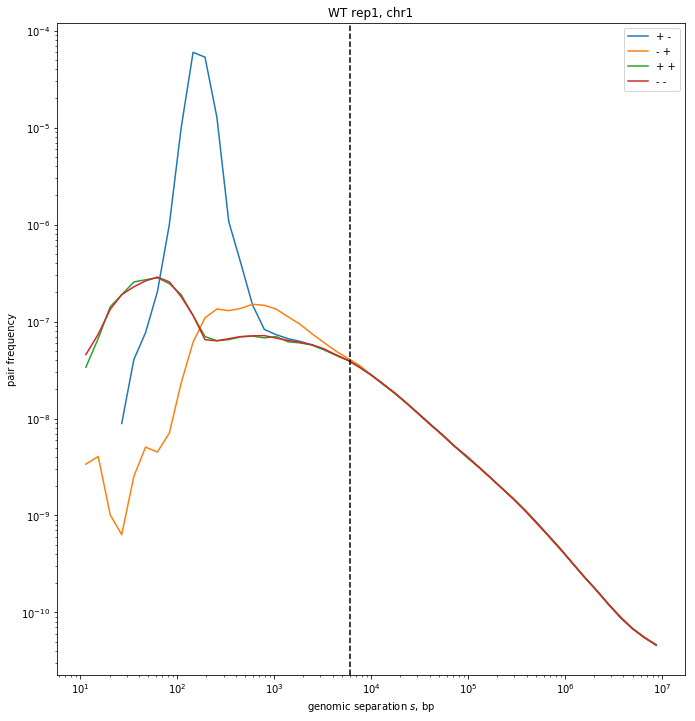

In [8]:
plt.figure(figsize=(12, 12))

dmin = 10
dmax = int(1e7)

orientations = [
    ('+', '-'),
    ('-', '+'),
    ('+', '+'),
    ('-', '-')
]

grouped = df.groupby(['strand1', 'strand2'])

for s1, s2 in orientations:
    group = grouped.get_group((s1, s2))
    
    dbins, obs, areas = compute_scaling(
        group, 
        region1=[0, chromsizes[chrom]], 
        region2=[0, chromsizes[chrom]],
        dmin=dmin, 
        dmax=dmax)
    
    dmeans = np.sqrt(dbins[:-1] * dbins[1:])
    scaling = obs / areas
    plt.loglog(dmeans, scaling, label='{} {}'.format(s1, s2))

plt.xlabel(r'genomic separation $s$, bp')
plt.ylabel('pair frequency')
plt.legend()
plt.axvline(6000, c='k', ls='--')
plt.gca().set_aspect(1)
plt.title(f'WT rep1, {chrom}')